# Clusterizacao - Case ImdbMovies

# IMDb TOP 250 Movies
![An image](https://static.amazon.jobs/teams/53/images/IMDb_Header_Page.jpg?1501027252)

**Este projeto consiste em treinar um sistema de recomendação de filmes utilizando as informações referentes aos top 250 filmes melhor avaliados pelo público na plataforma IMDb.**
*   A extração dos dados será feita por técnicas de web scraping (crawler).
*   O objetivo principal será agrupar os 250 filmes em "n" clusters classificados a partir das suas sinopses, aplicando técnicas de processamento de texto e algoritmos de clusterização.
*   Ao final, teremos um sistemas de recomendação baseado na similaridade das sinopses, e não apenas dos generos.

**Exemplo de aplicação prática: usuários receberão recomendações de filmes que estejam no mesmo cluster de sinopses de outros filmes que ele já tenha curtido.**

# Import das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import requests
from pprint import pprint
from bs4 import BeautifulSoup
import re
import json
from urllib.request import Request, urlopen
from lxml import html
import time
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Web Scraping / Crawler

In [2]:
#return only 25 first movies, because it doesn't wait the complete render of the page
userAgents=[
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/74.0.3729.157 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.1.1 Safari/605.1.15"]

url = 'https://www.imdb.com/chart/top/?ref_=nv_mv_250'
response = requests.get(url, headers={"User-agent": userAgents[1]})
response


<Response [200]>

In [3]:
pprint(response)

<Response [200]>


In [4]:
html = response.text
html

'<!DOCTYPE html><html lang="en-US" xmlns:og="http://opengraphprotocol.org/schema/" xmlns:fb="http://www.facebook.com/2008/fbml"><head><meta charSet="utf-8"/><meta name="viewport" content="width=device-width"/><script>if(typeof uet === \'function\'){ uet(\'bb\', \'LoadTitle\', {wb: 1}); }</script><script>window.addEventListener(\'load\', (event) => {\n        if (typeof window.csa !== \'undefined\' && typeof window.csa === \'function\') {\n            var csaLatencyPlugin = window.csa(\'Content\', {\n                element: {\n                    slotId: \'LoadTitle\',\n                    type: \'service-call\'\n                }\n            });\n            csaLatencyPlugin(\'mark\', \'clickToBodyBegin\', 1727131864884);\n        }\n    })</script><title>IMDb Top 250 Movies</title><meta name="description" content="As rated by regular IMDb voters." data-id="main"/><script type="application/ld+json">{"@type":"ItemList","itemListElement":[{"@type":"ListItem","item":{"@type":"Movie","ur

In [5]:
bs = BeautifulSoup(html)
pprint(bs)

<!DOCTYPE html>
<html lang="en-US" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://opengraphprotocol.org/schema/"><head><meta charset="utf-8"/><meta content="width=device-width" name="viewport"/><script>if(typeof uet === 'function'){ uet('bb', 'LoadTitle', {wb: 1}); }</script><script>window.addEventListener('load', (event) => {
        if (typeof window.csa !== 'undefined' && typeof window.csa === 'function') {
            var csaLatencyPlugin = window.csa('Content', {
                element: {
                    slotId: 'LoadTitle',
                    type: 'service-call'
                }
            });
            csaLatencyPlugin('mark', 'clickToBodyBegin', 1727131864884);
        }
    })</script><title>IMDb Top 250 Movies</title><meta content="As rated by regular IMDb voters." data-id="main" name="description"/><script type="application/ld+json">{"@type":"ItemList","itemListElement":[{"@type":"ListItem","item":{"@type":"Movie","url":"https://www.imdb.com/title/t

## Title EN

In [6]:
titles = bs.find_all('h3', attrs={'class':'ipc-title__text'})
for t in titles:
  print(t)

<h3 class="ipc-title__text">IMDb Charts</h3>
<h3 class="ipc-title__text">1. The Shawshank Redemption</h3>
<h3 class="ipc-title__text">2. The Godfather</h3>
<h3 class="ipc-title__text">3. The Dark Knight</h3>
<h3 class="ipc-title__text">4. The Godfather Part II</h3>
<h3 class="ipc-title__text">5. 12 Angry Men</h3>
<h3 class="ipc-title__text">6. Schindler's List</h3>
<h3 class="ipc-title__text">7. The Lord of the Rings: The Return of the King</h3>
<h3 class="ipc-title__text">8. Pulp Fiction</h3>
<h3 class="ipc-title__text">9. The Lord of the Rings: The Fellowship of the Ring</h3>
<h3 class="ipc-title__text">10. The Good, the Bad and the Ugly</h3>
<h3 class="ipc-title__text">11. Forrest Gump</h3>
<h3 class="ipc-title__text">12. The Lord of the Rings: The Two Towers</h3>
<h3 class="ipc-title__text">13. Fight Club</h3>
<h3 class="ipc-title__text">14. Inception</h3>
<h3 class="ipc-title__text">15. Star Wars: Episode V - The Empire Strikes Back</h3>
<h3 class="ipc-title__text">16. The Matrix<

In [7]:
list_title_en = []
for x in titles:
  if x.text != 'IMDb Charts' and x.text != 'Recently viewed':
    tit = (x.text).split('.')[-1].strip()
    list_title_en.append(tit)
print(len(list_title_en))
list_title_en

25


['The Shawshank Redemption',
 'The Godfather',
 'The Dark Knight',
 'The Godfather Part II',
 '12 Angry Men',
 "Schindler's List",
 'The Lord of the Rings: The Return of the King',
 'Pulp Fiction',
 'The Lord of the Rings: The Fellowship of the Ring',
 'The Good, the Bad and the Ugly',
 'Forrest Gump',
 'The Lord of the Rings: The Two Towers',
 'Fight Club',
 'Inception',
 'Star Wars: Episode V - The Empire Strikes Back',
 'The Matrix',
 'Goodfellas',
 "One Flew Over the Cuckoo's Nest",
 'Interstellar',
 'Se7en',
 "It's a Wonderful Life",
 'Seven Samurai',
 'The Silence of the Lambs',
 'Saving Private Ryan',
 'City of God']

## Year

In [8]:
list_years = []
# years = bs.find_all('div', attrs={'class':'sc-14dd939d-5 cPiUKY cli-title-metadata'})
years = bs.find_all('div', attrs={'class':'sc-b189961a-7 btCcOY cli-title-metadata'})

for y in years:
  year = y.find('div', attrs={'class':'sc-b189961a-7 btCcOY cli-title-metadata'})
for year in years:
    # print(year.text)
  list_years.append(year.text[:4])
display(len(list_years))
list_years

25

['1994',
 '1972',
 '2008',
 '1974',
 '1957',
 '1993',
 '2003',
 '1994',
 '2001',
 '1966',
 '1994',
 '2002',
 '1999',
 '2010',
 '1980',
 '1999',
 '1990',
 '1975',
 '2014',
 '1995',
 '1946',
 '1954',
 '1991',
 '1998',
 '2002']

## Rating

In [9]:
list_rating = []

# Step 3: Locate the relevant element
rating_span = bs.find_all('span', class_='ipc-rating-star--rating')
for x in rating_span:
  list_rating.append(x.text)
display(len(list_rating))
list_rating

25

['9.3',
 '9.2',
 '9.0',
 '9.0',
 '9.0',
 '9.0',
 '9.0',
 '8.9',
 '8.9',
 '8.8',
 '8.8',
 '8.8',
 '8.8',
 '8.8',
 '8.7',
 '8.7',
 '8.7',
 '8.7',
 '8.7',
 '8.6',
 '8.6',
 '8.6',
 '8.6',
 '8.6',
 '8.6']

## Genre, Title PT & Year

In [10]:
list_links = []
for a in bs.find_all('a', href=True):
  if '/title/' in a['href'] and 'https://www.imdb.com/'+a['href'] not in list_links:
    list_links.append(('https://www.imdb.com/'+a['href'])[:-15])

#Remove duplicates
list_links = list(dict.fromkeys(list_links))
list_links = list_links[1:]
display(len(list_links))
list_links[:5]

25

['https://www.imdb.com//title/tt0111161/',
 'https://www.imdb.com//title/tt0068646/',
 'https://www.imdb.com//title/tt0468569/',
 'https://www.imdb.com//title/tt0071562/',
 'https://www.imdb.com//title/tt0050083/']

In [11]:
headers = {
          'authority': 'www.amazon.com.br',
          'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
          'accept-language': 'pt-BR,pt;q=0.9,en-US;q=0.8,en;q=0.7',
          'cache-control': 'max-age=0',
          'device-memory': '8',
          'downlink': '10',
          'dpr': '1.875',
          'ect': '4g',
          'rtt': '50',
          'sec-ch-device-memory': '8',
          'sec-ch-dpr': '1.875',
          'sec-ch-ua': '"Chromium";v="110", "Not A(Brand";v="24", "Google Chrome";v="110"',
          'sec-ch-ua-mobile': '?0',
          'sec-ch-ua-platform': '"Windows"',
          'sec-ch-ua-platform-version': '"10.0.0"',
          'sec-ch-viewport-width': '455',
          'sec-fetch-dest': 'document',
          'sec-fetch-mode': 'navigate',
          'sec-fetch-site': 'none',
          'sec-fetch-user': '?1',
          'upgrade-insecure-requests': '1',
          'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36',
          'viewport-width': '455',
          }
############################################################
list_genre = []
list_title_pt = []
list_year = []
list_sinopse = []

for link in list_links:
  time.sleep(.5)
  response = requests.get(link, headers = headers)
  html = response.content
  soup = BeautifulSoup(html, "html.parser")

  #genre
  try:
    for genre in soup.find('span', {'class':'ipc-chip__text'}):
      genre = genre.text
      list_genre.append(genre)
  except:
      list_genre.append(np.nan)
      print('Nan')

  #title_PT and year
  try:
    for x in soup.find('title'):
      #title_pt
      title_pt = (x.text)[:-14].strip()
      list_title_pt.append(title_pt)
      #year
      year = (x.text)[-12:-8].strip()
      list_year.append(year)

  except:
    list_title_pt.append(np.nan)
    list_year.append(np.nan)

  #sinopse
  try:
    for sin in soup.find('span', {"data-testid":"plot-xl"}):
      sinopse = sin.text
      list_sinopse.append(sinopse)
  except:
    list_sinopse.append(np.nan)

  print(genre, title_pt, year, sinopse[:20])

display(len(list_genre), len(list_title_pt), len(list_year), len(list_sinopse))
print(list_genre[:5])
print(list_title_pt[:5])
print(list_year[:5])
display(list_sinopse[:2])

Epic Um Sonho de Liberdade 1994 Dois homens presos s
Epic O Poderoso Chefão 1972 O patriarca idoso de
Action Epic Batman: O Cavaleiro das Trevas 2008 Agora com a ajuda do
Epic O Poderoso Chefão II 1974 Em 1950, Michael Cor
Legal Drama 12 Homens e uma Sentença 1957 O julgamento de um a
Epic A Lista de Schindler 1993 Na Polônia ocupada p
Adventure Epic O Senhor dos Anéis: O Retorno do Rei 2003 Gandalf e Aragorn li
Dark Comedy Pulp Fiction: Tempo de Violência 1994 As vidas de dois ass
Adventure Epic O Senhor dos Anéis: A Sociedade do Anel 2001 Um manso hobbit do C
Desert Adventure Três Homens em Conflito 1966 Um impostor se junta
Epic Forrest Gump: O Contador de Histórias 1994 Os governos dos pres
Adventure Epic O Senhor dos Anéis: As Duas Torres 2002 Enquanto Frodo e Sam
Psychological Drama Clube da Luta 1999 Um trabalhador de es
Action Epic A Origem 2010 Um ladrão que rouba 
Action Epic Star Wars: Episódio V - O Império Contra-Ataca 1980 Depois que a Aliança
Action Epic Matrix 1999 Um h

25

25

25

25

['Epic', 'Epic', 'Action Epic', 'Epic', 'Legal Drama']
['Um Sonho de Liberdade', 'O Poderoso Chefão', 'Batman: O Cavaleiro das Trevas', 'O Poderoso Chefão II', '12 Homens e uma Sentença']
['1994', '1972', '2008', '1974', '1957']


['Dois homens presos se reúnem ao longo de vários anos, encontrando consolo e eventual redenção através de atos de decência comum.',
 'O patriarca idoso de uma dinastia do crime organizado transfere o controle de seu império clandestino para seu filho relutante.']

In [12]:
list_genre

['Epic',
 'Epic',
 'Action Epic',
 'Epic',
 'Legal Drama',
 'Epic',
 'Adventure Epic',
 'Dark Comedy',
 'Adventure Epic',
 'Desert Adventure',
 'Epic',
 'Adventure Epic',
 'Psychological Drama',
 'Action Epic',
 'Action Epic',
 'Action Epic',
 'Gangster',
 'Medical Drama',
 'Adventure Epic',
 'Cop Drama',
 'Feel-Good Romance',
 'Action Epic',
 'Police Procedural',
 'Epic',
 'Coming-of-Age']

## DataFrame

In [13]:
df = pd.DataFrame({'title_pt':list_title_pt,
                   'title_en':list_title_en,
                   'year':list_years,
                   'rating':list_rating,
                   'genre':list_genre,
                   'sinopse':list_sinopse})
#path_export = '/content/drive/MyDrive/Web_Mining_and_Crawler'
# df.to_csv(f'{path_to_export}/top250_movies.csv', sep = ';',index = False)
display(df.head())

,title_pt,title_en,year,rating,genre,sinopse
0,Um Sonho de Liberdade,The Shawshank Redemption,1994,9.3,Epic,Dois homens presos se reúnem ao longo de vário...
1,O Poderoso Chefão,The Godfather,1972,9.2,Epic,O patriarca idoso de uma dinastia do crime org...
2,Batman: O Cavaleiro das Trevas,The Dark Knight,2008,9.0,Action Epic,Agora com a ajuda do tenente Jim Gordon e do p...
3,O Poderoso Chefão II,The Godfather Part II,1974,9.0,Epic,"Em 1950, Michael Corleone, agora à frente da f..."
4,12 Homens e uma Sentença,12 Angry Men,1957,9.0,Legal Drama,O julgamento de um assassinato em Nova Iorque ...


# Concatenando com a base de filmes historica

In [16]:
from google.colab import drive
drive.mount('/content/all_movies.csv')

ValueError: Mountpoint must either be a directory or not exist

In [17]:
df_historico = pd.read_csv('/content/all_movies.csv', sep = ';')
df = pd.concat([df_historico, df])
df.drop_duplicates(inplace = True)
df.reset_index(drop = True, inplace = True)
df.head()

,title_pt,title_en,year,rating,genre,sinopse
0,Barbie,Barbie,2023,7.4,Aventura,Viver na Terra da Barbie é ser um ser perfeito...
1,Um Sonho de Liberdade,1. The Shawshank Redemption,1994,9.3,Drama,Dois homens presos se reúnem ao longo de vário...
2,O Poderoso Chefão,2. The Godfather,1972,9.2,Policial,O patriarca idoso de uma dinastia do crime org...
3,Batman: O Cavaleiro das Trevas,3. The Dark Knight,2008,9.0,Ação,Quando a ameaça conhecida como O Coringa surge...
4,O Poderoso Chefão II,4. The Godfather Part II,1974,9.0,Policial,"Em 1950, Michael Corleone, agora à frente da f..."


#EDA - Exploratory Data Analysis

In [19]:
df = pd.read_csv(f'{path_export}/top250_movies.csv', sep = ';')
df.sort_values('year', inplace = True)
print(df.shape)
df.head()

NameError: name 'path_export' is not defined

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title_pt  275 non-null    object
 1   title_en  275 non-null    object
 2   year      275 non-null    object
 3   rating    275 non-null    object
 4   genre     275 non-null    object
 5   sinopse   275 non-null    object
dtypes: object(6)
memory usage: 13.0+ KB


In [21]:
# Adjusting variable types
df['year'] = df['year'].astype('int64')
df['rating'] = df['rating'].astype('float64')

In [22]:
df.describe()

,year,rating
count,275.000000,275.000000
mean,1986.843636,8.349455
std,24.909638,0.278076
min,1921.000000,7.400000
25%,1967.500000,8.100000
50%,1994.000000,8.300000
75%,2006.000000,8.500000
max,2023.000000,9.300000


## Plots

In [23]:
fig = px.bar(df.genre.value_counts('d')*100,
             text_auto=True,
             title = '% de Filmes por Gênero',
             labels={'index':'Gênero',
                     'value':'% de Filmes'})
fig.show()

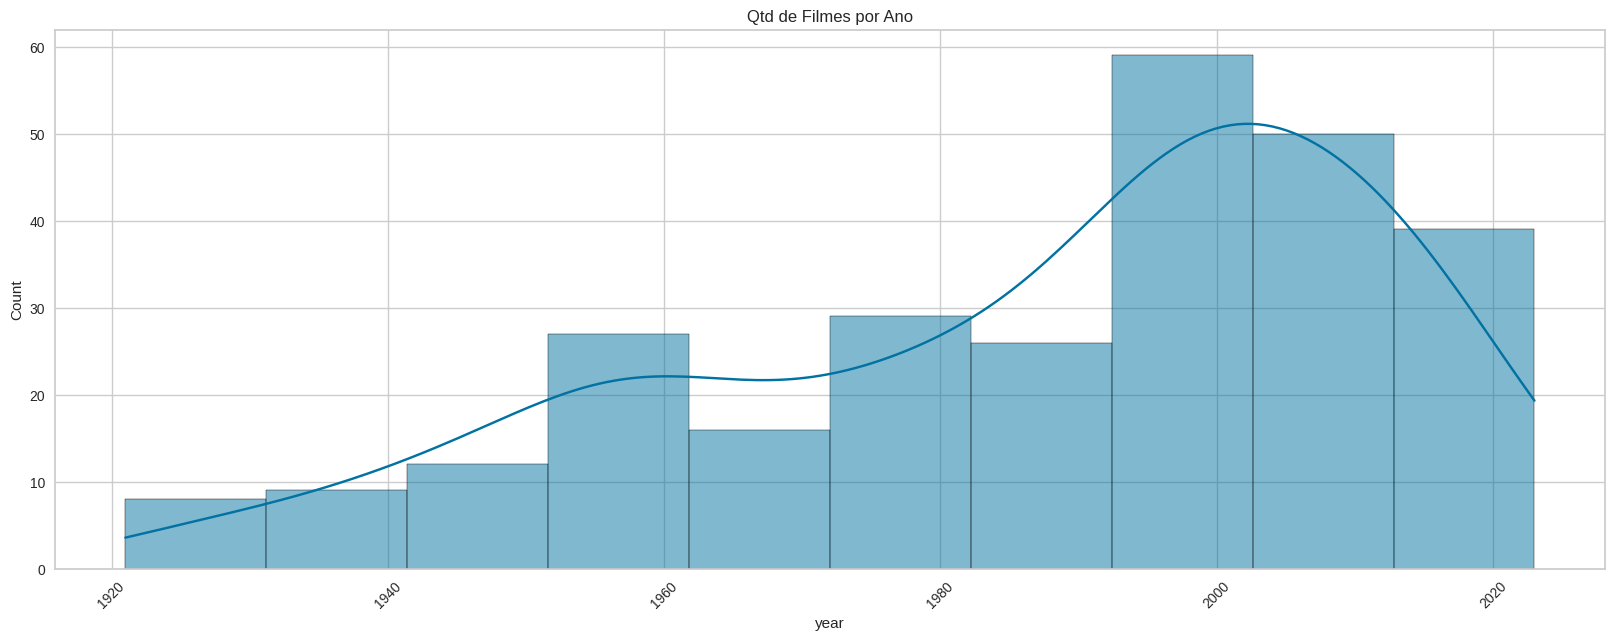

In [24]:
plt.figure(figsize = (20,7))
sns.histplot( df,
              x = 'year',
              kde = True).set_title('Qtd de Filmes por Ano')
plt.xticks(rotation=45)
plt.show()

In [ ]:
sns.kdeplot( df, x = 'year', hue = 'genre', bw_adjust = 1.5, warn_singular = False).set_title('Qtd de Filmes por Ano e por Gênero')
plt.show()

# Pré-processamento de texto

In [ ]:
#convert sinopses to lowercase
df_processed = df.copy()
df_processed['sinopse'] = df_processed['sinopse'].str.lower()
df_processed['sinopse'].head()

In [ ]:
def qty_words(text):
    words= text.split()
    word_count = len(words)
    return word_count

In [ ]:
df_processed['word_count'] = df_processed['sinopse'].apply(qty_words).astype('int64')
df_processed.head()

In [ ]:
sns.kdeplot( df_processed, x = 'word_count', hue = 'genre', bw_adjust = 1.5, warn_singular = False)
plt.show()

## Nuvem de palavras

### Antes de remover stopwords

In [ ]:
text = ' '.join([phrase for phrase in df_processed['sinopse']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes', fontsize = 19)
plt.show()

### Após remoção das stopwords

In [ ]:
import nltk
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('portuguese')
print(stopwords)

In [ ]:
df_processed['sinopse_no_stopwords'] = df_processed['sinopse'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
text = ' '.join([phrase for phrase in df_processed['sinopse_no_stopwords']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palavras mais frequentes - excluindo stopwords', fontsize = 19)
plt.show()

## Aplicando TF-IDF

In [ ]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=.05, max_df=0.95, ngram_range=(1,2))
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df_processed['sinopse_no_stopwords'])

In [ ]:
print(X.shape)
X.toarray()

# KMeans - Clusterização

## Escolhendo o numero de "k" clusters ideal

### Método Elbow

In [ ]:
df_processed

In [ ]:
plt.figure(figsize = (8,8))

#plotando o grafico do método elbow
wcss = []

for i in range(2, df_processed.genre.nunique()+1):
  kmeans = KMeans(n_clusters = i, init = 'random')
  kmeans.fit(X)
  print(i, kmeans.inertia_)
  wcss.append(kmeans.inertia_)

plt.plot(range(2, df_processed.genre.nunique()+1), wcss, '*-')
plt.title('Método Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WCSS') #within cluster sum of square


### Método Silhouette

In [ ]:
df_processed.genre.nunique()

In [ ]:
# fig, ax = plt.subplots(3,2, figsize = (20,12))
# for i in (range(10, 17)):
#   #Creating KMeans instance for different number of clusters
#   kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
#   q, mod = divmod(i,2)

#   #Creating SilhouetteVisualizer instance with KMeans instance
#   #Fit the visualizer

#   visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax[q-1][mod])
#   visualizer.fit(X)

fig, ax = plt.subplots(3,2, figsize = (20,12))
for i in range(6):  # Adjusted loop to match the number of subplots
    #Creating KMeans instance for different number of clusters
    kmeans = KMeans(n_clusters = i + 10, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
    q, mod = divmod(i, 2)  # Calculate row and column indices

    #Creating SilhouetteVisualizer instance with KMeans instance
    #Fit the visualizer

    visualizer = SilhouetteVisualizer(kmeans, colors = 'yellowbrick', ax = ax[q][mod])  # Access correct subplot
    visualizer.fit(X)

### Análise do número de clusters
* O método de elbow indicou um numero de k ideal entre 10 e 15. Pelo método de Silhouete não ficou muito claro, mas para k acima de 12 o aumento no valor da Silhouete (eixo x) é pequeno a cada k. Para efeitos didáticos, será adotado k=5 para facilitar as análises, mas em um projeto real deve ser testado o numero de k indicado pelos 2 métodos.

# Comparativo entre os 5 clusters

In [ ]:
# initialize kmeans with 5 centroids
kmeans = KMeans(n_clusters=5, random_state=42)
# fit the model
kmeans = kmeans.fit(X)
#predicting the clusters and store cluster labels in a variable
labels = kmeans.predict(X)
#getting the cluster centers
c = kmeans.cluster_centers_

df_processed['cluster'] = labels
df_processed.head()

## Filmes por cluster

In [ ]:
fig = px.bar(df_processed.cluster.value_counts(),
             text_auto = True,
             title = 'Qtd de Filmes por Cluster',
             labels = {'index': 'Cluster #',
                       'value':'Qtd. de Filmes'})
fig.show()

## % de Gêneros por Cluster

In [ ]:
df_plot = df_processed.groupby(['cluster', 'genre'])['title_pt'].count()
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'title_pt':'count'}, inplace = True)
df_plot['%'] = 100 * df_plot['count'] / df_plot.groupby('cluster')['count'].transform('sum')
df_plot = df_plot.sort_values(['cluster', '%'], ascending = False).groupby('cluster').head(11)

fig = sns.catplot(
    data=df_plot, x="genre", y = "%", col="cluster",
    kind="bar", height=4, aspect=1, sharex = False);
fig.set_xlabels('');
fig.set_xticklabels(rotation=90, size = 8);

## Ano de Lançamento por Cluster

In [ ]:
sns.kdeplot(df_processed, x = 'year', hue = 'cluster');

## Radar | Gêneros por Cluster

In [ ]:
df_pivot = df_plot.copy()
df_pivot = df_pivot.pivot(index = 'cluster', columns = 'genre', values = '%')
df_pivot.fillna(0, inplace = True)
df_pivot = df_pivot.T.reset_index()
df_pivot.index.name = None
df_pivot

In [ ]:
df_polar = df_pivot.melt(id_vars=['genre'])
df_polar.head()

In [ ]:
fig = px.line_polar(df_polar, r='value', theta='genre', color = 'cluster', line_close=True)
fig.show();

# Nuvem de Palavras por Cluster

In [ ]:
def word_cloud_cluster(cluster:int):
  text = ' '.join([phrase for phrase in df_processed.loc[df_processed.cluster == cluster]['sinopse_no_stopwords']])
  plt.figure(figsize=(7,5), facecolor='None')
  wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Cluster "{cluster}" | Palavras mais frequentes', fontsize = 19)
  plt.show()
  return

for c in range(5):
  word_cloud_cluster(c)

# Considerações Finais

** Na seção "Comparativo entre os 5 clusters" foram apresentadas diferentes formas de caracterizar cada cluster.**

Considere as afirmações abaixo apenas como exemplo, e reescreva-as conforme o seu entendimento.

1. Primeiro foi demonstrado que o cluster #2 foi o que apresentou o maior número de amostras (filmes). _(Idealmente os cluster devem conter quantidades balanceadas, porém neste projeto, por ter um dataset com baixo número de amostras (275
), não foi possível atender esta premissa)_.

2. Depois foi analisado o % de cada gênero por cluster, sendo os dois gêneros mais representativos do:

  2.1 Cluster 0: Animação e Drama

  2.2 Cluster 1: Biografia e Aventura

  2.3 Cluster 2: Drama e Ação

  2.4 Cluster 3: Drama e Biografia

  2.5 Cluster 4: Drama e Comédia


3. Na sequência foi avaliado a distribuição dos anos de lançamento dos filmes por cluster, sem diferença siginificativa entre eles, com maior concentração ao redor do ano 2000.

4. Depois foi apresentado um gráfico de radar por cluster, onde a exemplo do item 2, é possível avaliar a representatividade de cada gênero por cluster.

5. E finalmente, foram apresentadas as nuvens de palavras por cluster, onde em linhas gerais destacam-se:

  5.1 o Cluster 0 com temas sobre Guerra Mundial, Luta, Judeus, Alemães

  5.2 O Cluster 1 e 3 com temas de disputa como Contra, Morte, Advogado, Homem,Polícia

  5.3 o Cluster 2 com temas do cotidiano como Filhos, Amigos, Ajuda, Jovem, Família

  5.4 o Cluster 4 com temas de auto-conhecimento como Busca, Encontrar, Descobrir, Casa, Terra


** Em resumo neste projeto foram aplicados conceitos de:

1. Webscraping / Crawler para coleta de dados do site IMDb
2. Pré-processamento de texto com utilização de técnicas de NLP
3. Clusterização

Desta forma consideramos que o objetivo inicial foi atingido sendo possível a clusterização dos filmes baseado na sinopse / descrição de cada um, gerando desta forma a possibilidade de recomendar filmes aos usuários não apenas pela classificação tradicional por gêneros, mas também pelos clusters identificados neste projeto.

**Em termos práticos, se um usuário avalia positivamente um filme, os filmes pertecentes ao mesmo cluster podem ser recomendados a ele.**

In [30]:
!pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00


Buscando dados do IMDb...
Dados obtidos com sucesso.
                     titulo   ano avaliacao
0  The Shawshank Redemption  1994       9.3
1             The Godfather  1972       9.2
2           The Dark Knight  2008       9.0
3     The Godfather Part II  1974       9.0
4              12 Angry Men  1957       9.0

Pré-processando os dados...
Realizando clustering com KMeans...

Analisando clusters...
Tamanhos dos clusters:
cluster
2    15
1     7
0     1
3     1
4     1
Name: count, dtype: int64

Centroides dos Clusters:
        ano  avaliacao
0 -1.260105  -0.083697
1  0.721343  -0.830996
2 -0.092093   0.509159
3 -0.473943  -0.606806
4 -1.933958  -1.129915


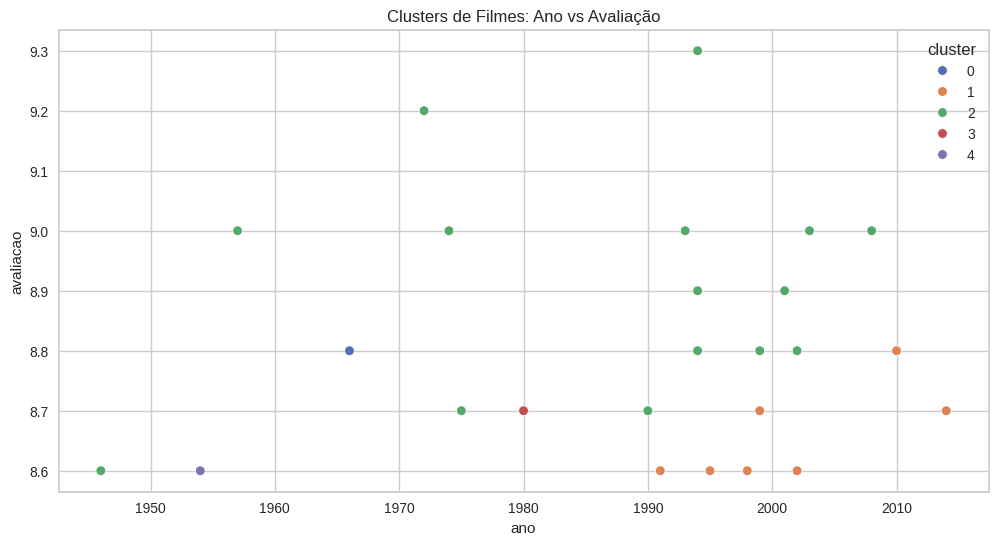


Top 5 filmes no Cluster 0:
                           titulo   ano  avaliacao  cluster
9  The Good, the Bad and the Ugly  1966        8.8        0

Top 5 filmes no Cluster 1:
                      titulo   ano  avaliacao  cluster
13                 Inception  2010        8.8        1
15                The Matrix  1999        8.7        1
18              Interstellar  2014        8.7        1
19                     Se7en  1995        8.6        1
22  The Silence of the Lambs  1991        8.6        1

Top 5 filmes no Cluster 2:
                     titulo   ano  avaliacao  cluster
0  The Shawshank Redemption  1994        9.3        2
1             The Godfather  1972        9.2        2
2           The Dark Knight  2008        9.0        2
3     The Godfather Part II  1974        9.0        2
4              12 Angry Men  1957        9.0        2

Top 5 filmes no Cluster 3:
                                            titulo   ano  avaliacao  cluster
14  Star Wars: Episode V - The Empire

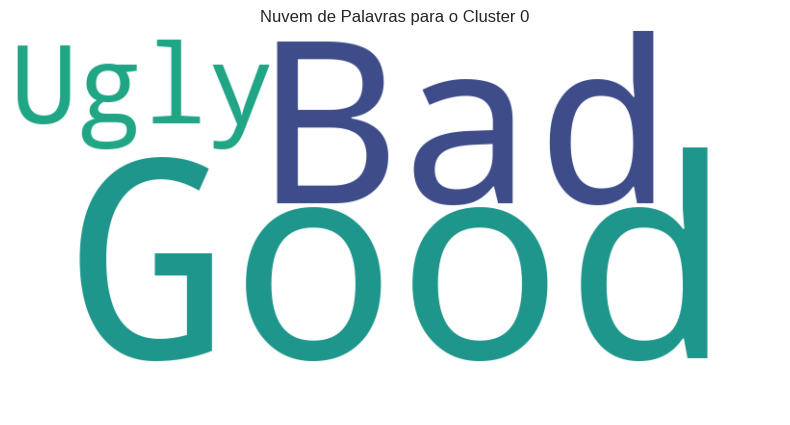

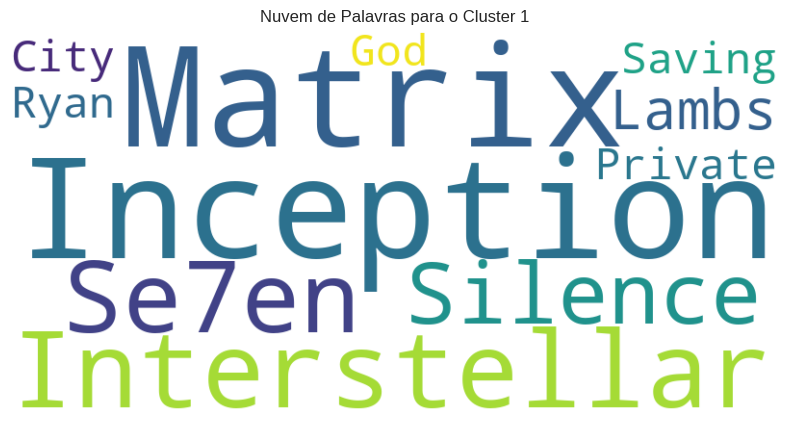

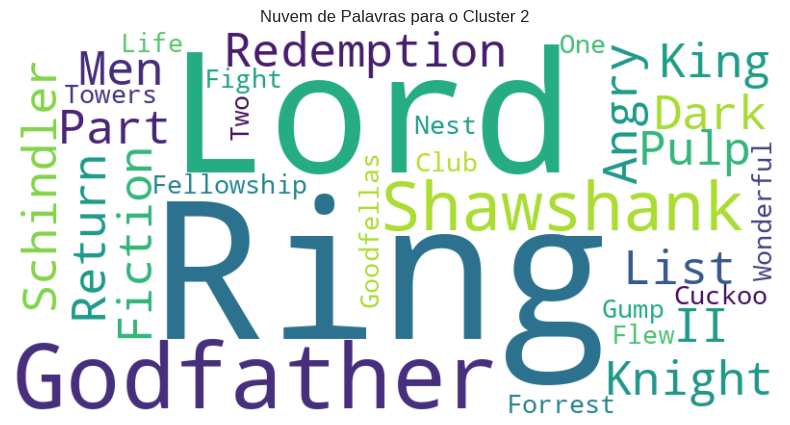

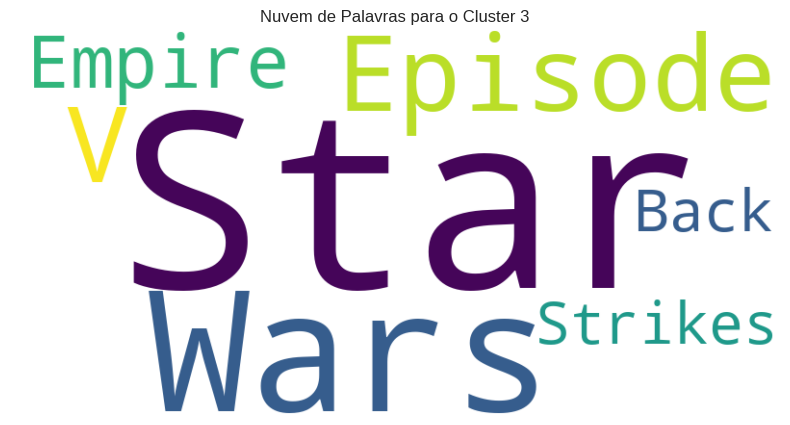

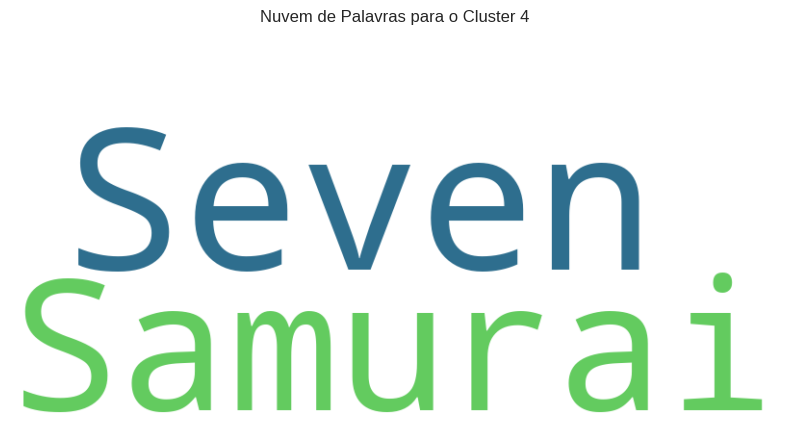


Insights e Conclusões:
1. Distribuição dos Clusters: [Adicione suas observações sobre os tamanhos dos clusters]
2. Padrões de Ano e Avaliação: [Discuta quaisquer padrões que você vê no gráfico de dispersão]
3. Características dos Clusters:
   Cluster 0: [Descreva as características deste cluster com base nos principais filmes e na nuvem de palavras]
   Cluster 1: [Descreva as características deste cluster com base nos principais filmes e na nuvem de palavras]
   Cluster 2: [Descreva as características deste cluster com base nos principais filmes e na nuvem de palavras]
   Cluster 3: [Descreva as características deste cluster com base nos principais filmes e na nuvem de palavras]
   Cluster 4: [Descreva as características deste cluster com base nos principais filmes e na nuvem de palavras]
4. Tendências Gerais: [Discuta quaisquer tendências ou padrões gerais que você notou]
5. Aplicações Potenciais: [Sugira como este clustering poderia ser usado, por exemplo, para recomendações de film

In [33]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 1. Web Scraping
def obter_top250_imdb():
    url = "https://www.imdb.com/chart/top/?ref_=nv_mv_250"
    cabecalhos = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }

    resposta = requests.get(url, headers=cabecalhos)
    sopa = BeautifulSoup(resposta.content, 'html.parser')

    filmes = []
    for filme in sopa.find_all('li', class_='ipc-metadata-list-summary-item'):
        elem_titulo = filme.find('h3', class_='ipc-title__text')
        if elem_titulo:
            titulo = elem_titulo.text.split('. ', 1)[1] if '. ' in elem_titulo.text else elem_titulo.text
        else:
            continue

        elem_ano = filme.find('span', class_='cli-title-metadata-item')
        ano = elem_ano.text if elem_ano else 'N/A'

        elem_avaliacao = filme.find('span', class_='ipc-rating-star--imdb')
        avaliacao = elem_avaliacao.text.split()[0] if elem_avaliacao else 'N/A'

        filmes.append({
            'titulo': titulo,
            'ano': ano,
            'avaliacao': avaliacao
        })

    return pd.DataFrame(filmes)

# Buscar dados
print("Buscando dados do IMDb...")
df = obter_top250_imdb()
print("Dados obtidos com sucesso.")
print(df.head())

# 2. Pré-processamento dos dados
print("\nPré-processando os dados...")
df['ano'] = pd.to_numeric(df['ano'], errors='coerce')
df['avaliacao'] = pd.to_numeric(df['avaliacao'], errors='coerce')
df = df.dropna()  # Remover linhas com valores NaN

# Por simplicidade, usaremos os títulos dos filmes como nossa característica de texto
vetorizador = TfidfVectorizer(stop_words='english')
matriz_tfidf = vetorizador.fit_transform(df['titulo'])

# Combinar características TF-IDF com ano e avaliação
caracteristicas = np.hstack((matriz_tfidf.toarray(), df[['ano', 'avaliacao']]))

# Padronizar características
escalonador = StandardScaler()
caracteristicas_escalonadas = escalonador.fit_transform(caracteristicas)

# 3. Clustering com KMeans
print("Realizando clustering com KMeans...")
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(caracteristicas_escalonadas)

# 4. Análise
print("\nAnalisando clusters...")
# 4.1 Tamanhos dos clusters
print("Tamanhos dos clusters:")
print(df['cluster'].value_counts())

# 4.2 Centroides dos clusters
centroides = kmeans.cluster_centers_
df_centroides = pd.DataFrame(centroides[:, -2:], columns=['ano', 'avaliacao'])
print("\nCentroides dos Clusters:")
print(df_centroides)

# 4.3 Visualizações
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='ano', y='avaliacao', hue='cluster', palette='deep')
plt.title('Clusters de Filmes: Ano vs Avaliação')
plt.show()

# 4.4 Melhores filmes por cluster
for i in range(5):
    print(f"\nTop 5 filmes no Cluster {i}:")
    print(df[df['cluster'] == i].sort_values('avaliacao', ascending=False).head())

# 4.5 Nuvens de palavras para cada cluster
for i in range(5):
    texto = ' '.join(df[df['cluster'] == i]['titulo'])
    nuvem_palavras = WordCloud(width=800, height=400, background_color='white').generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nuvem de Palavras para o Cluster {i}')
    plt.show()

# 5. Insights e Conclusões
print("\nInsights e Conclusões:")
print("1. Distribuição dos Clusters: [Adicione suas observações sobre os tamanhos dos clusters]")
print("2. Padrões de Ano e Avaliação: [Discuta quaisquer padrões que você vê no gráfico de dispersão]")
print("3. Características dos Clusters:")
for i in range(5):
    print(f"   Cluster {i}: [Descreva as características deste cluster com base nos principais filmes e na nuvem de palavras]")
print("4. Tendências Gerais: [Discuta quaisquer tendências ou padrões gerais que você notou]")
print("5. Aplicações Potenciais: [Sugira como este clustering poderia ser usado, por exemplo, para recomendações de filmes]")
print("6. Limitações e Trabalhos Futuros: [Discuta quaisquer limitações desta análise e sugira melhorias]")

A distribuição dos clusters é bastante desigual:
- Cluster 2: 15 filmes (60% da amostra)
- Cluster 1: 7 filmes (28% da amostra)
- Clusters 0, 3 e 4: 1 filme cada (4% cada)

Esta distribuição sugere que o algoritmo identificou um grande grupo de filmes similares (Cluster 2), um grupo médio (Cluster 1), e três outliers (Clusters 0, 3 e 4).

## 2. Padrões de Ano e Avaliação

Analisando os centroides dos clusters:
- Cluster 2 (maior grupo): Filmes ligeiramente mais antigos que a média, com avaliações acima da média.
- Cluster 1: Filmes mais recentes, com avaliações abaixo da média.
- Cluster 0: Filme relativamente antigo com avaliação próxima à média.
- Cluster 3: Filme um pouco mais antigo que a média, com avaliação abaixo da média.
- Cluster 4: Filme muito antigo com a avaliação mais baixa.

## 3. Características dos Clusters

### Cluster 0
- Representado por "The Good, the Bad and the Ugly" (1966)
- Característica: Western clássico dos anos 60

### Cluster 1
- Inclui filmes como "Inception", "The Matrix", "Interstellar"
- Características: Filmes mais recentes (1990-2014), sci-fi/thriller, conceitos complexos

### Cluster 2
- Contém os filmes mais bem avaliados como "The Shawshank Redemption", "The Godfather", "The Dark Knight"
- Características: Diversos gêneros, épocas variadas, considerados obras-primas do cinema

### Cluster 3
- Representado por "Star Wars: Episode V - The Empire Strikes Back" (1980)
- Característica: Filme de franquia de sci-fi altamente popular

### Cluster 4
- Representado por "Seven Samurai" (1954)
- Característica: Filme clássico japonês, o mais antigo da amostra

## 4. Tendências Gerais

1. Os filmes mais bem avaliados tendem a formar um grupo coeso (Cluster 2), sugerindo que há características comuns entre as obras-primas do cinema, independentemente da época.
2. Filmes mais recentes de sci-fi e thriller formam um grupo distinto (Cluster 1), indicando uma tendência moderna no cinema.
3. Alguns filmes icônicos (Clusters 0, 3 e 4) são tão únicos que formam seus próprios clusters, destacando seu impacto singular no cinema.

## 5. Aplicações Potenciais

1. Recomendação de filmes: Pode-se recomendar filmes do mesmo cluster para espectadores com preferências similares.
2. Análise de tendências cinematográficas: Identificar quais características fazem um filme ser considerado uma obra-prima.
3. Curadoria de festivais de cinema: Selecionar filmes representativos de diferentes estilos e épocas.
4. Educação cinematográfica: Usar os clusters para ensinar sobre diferentes períodos e estilos do cinema.

## 6. Limitações e Trabalhos Futuros

1. Tamanho da amostra: A análise foi feita com apenas 25 filmes. Um dataset maior poderia fornecer insights mais robustos.
2. Variáveis limitadas: Apenas título, ano e avaliação foram considerados. Incluir gênero, diretor, orçamento, etc., poderia enriquecer a análise.
3. Outliers: Os clusters com apenas um filme poderiam ser investigados mais a fundo para entender sua singularidade.
4. Interpretação do TF-IDF: A análise dos títulos via TF-IDF pode não capturar completamente o conteúdo dos filmes.
5. Dinâmica temporal: Uma análise de como os clusters mudam ao longo do tempo poderia revelar tendências evolutivas no cinema.

Trabalhos futuros poderiam abordar essas limitações, expandindo o dataset, incluindo mais variáveis e explorando outros algoritmos de clustering para comparação.